In [75]:
import plotly.express as plx
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as st

In [76]:
DATA_PATH = "../../data/input"

# Data loading

In [77]:
# Help to identify a sample's closest QC pool for median normalization correction later on

def subbatch(x):
    if x['order'] <= 14 :
        return 0
    if x['order'] <= 26 :
        return 1
    if x['order'] <= 38 :
        return 2
    if x['order'] <= 50 :
        return 3
    if x['order'] <= 62 :
        return 4
    if x['order'] <= 74 :
        return 5
    if x['order'] <= 86 :
        return 6
    if x['order'] <= 101 :
        return 7
    else:
        return 8

In [78]:
df_acq = pd.read_csv(os.path.join(DATA_PATH, 'internship_acquisition_list.csv'))
df_acq[df_acq['class'].isin(['QC']) & (df_acq['batch'] == 1)].sort_values('order')

,sample,class,id,order,batch
91,20241106-297-QC1,QC,20241106-297-QC1,12,1
94,20241106-297-QC2,QC,20241106-297-QC2,13,1
95,20241106-297-QC3,QC,20241106-297-QC3,14,1
96,20241106-297-QC4,QC,20241106-297-QC4,26,1
97,20241106-297-QC5,QC,20241106-297-QC5,38,1
98,20241106-297-QC6,QC,20241106-297-QC6,50,1
99,20241106-297-QC7,QC,20241106-297-QC7,62,1
100,20241106-297-QC8,QC,20241106-297-QC8,74,1
101,20241106-297-QC9,QC,20241106-297-QC9,86,1
92,20241106-297-QC10,QC,20241106-297-QC10,100,1


In [92]:
df_data = pd.read_csv(os.path.join(DATA_PATH, 'internship_data_matrix.csv'))
df_feature_meta = pd.read_csv(os.path.join(DATA_PATH, 'internship_feature_metadata.csv'))

# Augment dataset with metadata
df_acq['sub_batch'] = df_acq.apply(lambda x : subbatch(x), axis=1)
df_data = df_data.merge(df_acq[['sample', 'class', 'order', 'batch', 'sub_batch']], on='sample')
df_data = df_data.melt(id_vars=['sample', 'class', 'order', 'batch', 'sub_batch'],value_name='intensity', var_name='feature')
df_data = df_data.merge(df_feature_meta[['feature', 'mz', 'rt']], on='feature')
df_data['feature_number'] = df_data['feature'].apply(lambda s : int(s.split('-')[1]))

# Filter classes, batch of interest and mass range of interest
df_data = df_data[df_data['class'].isin(['QC', 'Dunn', 'French', 'LMU']) & df_data['batch'] == 1]
df_glycans = df_feature_meta[df_feature_meta['mz'] > 500]
df_data = df_data.merge(df_glycans['feature'], on='feature', how='inner')

# Data processing

## 1 - Select features :
* which have a limited variability across quality check samples (CV < 30%)
* which are consistently detected across samples (70%)

In [93]:
# Remove features with outliers in QC to compute robust CV on features

df_QC = df_data[df_data['class'] == 'QC']
df_QC_summary = df_QC.groupby(['feature'])['intensity'].describe().reset_index()
df_QC_summary['lower_bound'] = 2.5*df_QC_summary['25%'] - 1.5*df_QC_summary['75%']
df_QC_summary['upper_bound'] = 2.5*df_QC_summary['75%'] - 1.5*df_QC_summary['25%']
df_QC = df_QC.merge(df_QC_summary[['feature', 'lower_bound', 'upper_bound']], on='feature')
print(f"Each QC sample has at least 1 outliers :\n{df_QC[(df_QC['intensity'] < df_QC['lower_bound']) | (df_QC['intensity'] > df_QC['upper_bound']) ].groupby('sample').size()}.")

# Since the features first selection step relies on CV per feature, we can just remove feature with outlier value for each sample
df_QC = df_QC[(df_QC['intensity'] >= df_QC['lower_bound']) & (df_QC['intensity'] <= df_QC['upper_bound']) ]

Each QC sample has at least 1 outliers :
sample
20241106-297-QC1      6
20241106-297-QC10     9
20241106-297-QC11     5
20241106-297-QC2     37
20241106-297-QC3      1
20241106-297-QC4      2
20241106-297-QC6     39
20241106-297-QC7     32
20241106-297-QC8      1
20241106-297-QC9      4
dtype: int64.


In [94]:
# Compute CV

cv_QC = df_QC.groupby('feature')['intensity'].agg(lambda x : x.std() / x.mean() * 100).reset_index().rename(columns={'intensity' : 'CV%'})
cv_QC.describe()

,CV%
count,248.000000
mean,20.206194
std,12.235200
min,2.416975
25%,14.056512
50%,17.015310
75%,22.907125
max,99.131709


According to [Instrumental Drift in Untargeted Metabolomics: Optimizing Data Quality with Intrastudy QC Samples](https://pmc.ncbi.nlm.nih.gov/articles/PMC10222478/#sec4-metabolites-13-00665), a accepted CV threshold for biomarker discovery is 20%. This work allows 30%.

In [95]:
# Select features which exhibit limited variability in QC

selected_feats = list(cv_QC[cv_QC['CV%'] <= 30]['feature'])
print(f"At this stage, {len(selected_feats)} features were selected")

At this stage, 219 features were selected


In [96]:
df_data_process = df_data[df_data['feature'].isin(selected_feats)]

We select features that are consistently detected across samples.
We consider that a feature is present in a sample if its intensity is above 400 (from previous analysis in EDA). Then we select features which are present in all samples at least 70% of the time.

In [97]:
df_data_process['detection'] = df_data_process['intensity'].apply(lambda x: x >= 400)
df_detect = df_data_process.groupby('feature').agg({'detection':lambda x : x.sum() / x.size})
detected_features = df_detect.loc[df_detect['detection'] < 0.7].index
print(f"At this stage, {len(detected_features)} features were selected")
df_data_process = df_data[df_data['feature'].isin(detected_features)]

At this stage, 39 features were selected


C:\Users\Philippine\AppData\Local\Temp\ipykernel_19180\2303838604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_process['detection'] = df_data_process['intensity'].apply(lambda x: x >= 400)


## 2 - Remove samples with outliers 

In [98]:
# Detect outliers

summ = df_data_process.groupby('feature')['intensity'].describe().reset_index()
summ['lower_bound'] = 2.5*summ['25%'] - 1.5*summ['75%']
summ['upper_bound'] = 2.5*summ['75%'] - 1.5*summ['25%']
df_data_process = df_data_process.merge(summ[['feature', 'lower_bound', 'upper_bound']], on='feature')
nb_outliers = df_data_process[(df_data_process['intensity'] < df_data_process['lower_bound']) | (df_data_process['intensity'] > df_data_process['upper_bound']) ]\
                .groupby(['class','sample']).size().reset_index()
nb_outliers = nb_outliers.rename(columns={0:'nb_outliers'})

Since there is at least 1 outlier per sample, we can discard samples based on a number of outliers.

In [99]:
# Filter samples

print(f"Number of samples per class before filtering :\n{df_data_process.drop_duplicates(['sample', 'class']).groupby('class').size()}")
samples_to_exclude = list(nb_outliers[(nb_outliers['nb_outliers'] > 4) & ~(nb_outliers['class'] == 'QC')]['sample'])
df_data_process = df_data_process[~df_data_process['sample'].isin(samples_to_exclude)].drop(['lower_bound', 'upper_bound'], axis=1)
print(f"Number of samples per class after filtering :\n{df_data_process.drop_duplicates(['sample', 'class']).groupby('class').size()}")

Number of samples per class before filtering :
class
Dunn      27
French    26
LMU       26
QC        11
dtype: int64
Number of samples per class after filtering :
class
Dunn      26
French    25
LMU       24
QC        11
dtype: int64


##  3- Rescale data to improve comparability

There are several ways to proceed.
* Global scaling normalization coefficient : ratio of peptide abundance to median peptide abundance measured across all samples
* Median pool normalisation : ratio of sample peptide abundance to peptide abundance in the 3 neighbouring QCs. This approach is preferred as it acounts for intra batch effects.

In [100]:
# Compute the QC pool metabolites median intensities for each data sub_batch
pools_medians = df_data[df_data['class'] == 'QC'].groupby(['sub_batch', 'feature'])['intensity'].median().reset_index()
pools_medians = pools_medians.sort_values(['feature', 'sub_batch'])\
                             .groupby('feature')\
                             .rolling(3, min_periods=2, center=True).median()\
                             .replace({'sub_batch':6.5}, 7).replace({'sub_batch':0.5}, 0)\
                             .reset_index('feature').rename(columns={'intensity' : 'med_QC_intensity'})

In [101]:
# Scale data intensities
df_data_corr = df_data.merge(pools_medians, on=['feature', 'sub_batch'], how='outer')
df_data_corr['intensity_raw'] = df_data_corr['intensity']
df_data_corr['intensity'] = df_data_corr['intensity'] / df_data_corr['med_QC_intensity']

## 4. Plot result

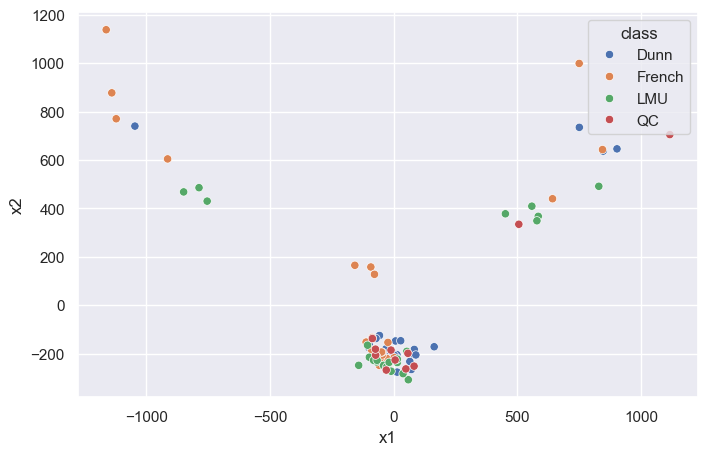

In [102]:
from sklearn.decomposition import PCA

df = df_data_process[['feature', 'intensity', 'sample', 'class']].groupby(['class','sample','feature']).first().unstack()
pca_2d = PCA(n_components=2)
X = df.to_numpy()
X_new = pca_2d.fit_transform(X)

sns.set(rc = {'figure.figsize':(8, 5)})
df_plot = pd.DataFrame(X_new, columns=['x1', 'x2'])
df_plot['class'] = [c for (c, i) in df.index]

fig = sns.scatterplot(df_plot, x='x1', y='x2', hue='class')
#fig.set_xlim((-5,5))
#fig.set_ylim((-5,5))

After data processing and feature engineering, we can observe that most data points cluster.

## 5 Final selection

In [103]:
print(f"Final curated list contains {df_data_process['feature'].nunique()} features and {df_data_process['sample'].nunique()} samples.")

Final curated list contains 39 features and 86 samples.


In [107]:
print(f"Selected features are : \n{df_data_process['feature'].unique()}\n")
print(f"Selected samples are : \n{df_data_process['sample'].unique()}")

Selected features are : 
['FT-051' 'FT-060' 'FT-065' 'FT-068' 'FT-071' 'FT-072' 'FT-079' 'FT-086'
 'FT-091' 'FT-115' 'FT-116' 'FT-126' 'FT-131' 'FT-146' 'FT-148' 'FT-151'
 'FT-153' 'FT-172' 'FT-174' 'FT-180' 'FT-183' 'FT-186' 'FT-188' 'FT-192'
 'FT-200' 'FT-202' 'FT-205' 'FT-206' 'FT-209' 'FT-217' 'FT-225' 'FT-235'
 'FT-238' 'FT-239' 'FT-241' 'FT-242' 'FT-243' 'FT-245' 'FT-249']

Selected samples are : 
['20241106-297-Dunn-1' '20241106-297-Dunn-10' '20241106-297-Dunn-11'
 '20241106-297-Dunn-12' '20241106-297-Dunn-13' '20241106-297-Dunn-14'
 '20241106-297-Dunn-15' '20241106-297-Dunn-16' '20241106-297-Dunn-17'
 '20241106-297-Dunn-18' '20241106-297-Dunn-19' '20241106-297-Dunn-2'
 '20241106-297-Dunn-20' '20241106-297-Dunn-22' '20241106-297-Dunn-23'
 '20241106-297-Dunn-24' '20241106-297-Dunn-25' '20241106-297-Dunn-26'
 '20241106-297-Dunn-27' '20241106-297-Dunn-3' '20241106-297-Dunn-4'
 '20241106-297-Dunn-5' '20241106-297-Dunn-6' '20241106-297-Dunn-7'
 '20241106-297-Dunn-8' '20241106-297-Dun